Final Submit DAW
<br>
Authors: Mychailo & Roberto

#  **New York State of Mind**

##  **Introduction**

This notebook presents the **final report** for our project in the module  
**Data Wrangling (DAW)**.  

It is based on two primary datasets:  

- [NYC 311 Service Requests](https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9/about_data)  
- [StreetEasy Data Dashboard](https://streeteasy.com/blog/data-dashboard/?utm_source=chatgpt.com)  

---

The project demonstrates a complete **data wrangling pipeline**, covering the topics of the LE's in this module.

1. **Importing** – retrieving and sampling real-world open data  
2. **Data Cleaning** – preparing data for analysis  
3. **Tranforming** – further preparation feature engineering  
4. **Joining** - joining the data
5. **Data Pipelines** – bla bla
6. **Reproducability** - bla bla

---

Our work follows the structure of the **commonly used data exploration framework**, 

---
<img src="./img/data_exploring.png">


-------------------------

## LE1 Importing
###  1. Workflow Overview

1. **Generate month range:**  
   For each year between the selected start and end years, we create `(start, end)` date pairs.  
   First we create quarterly ranges and then split them into the months.
   Example: `2024-01-01T00:00:00` → `2024-01-31T23:59:59` (M1 2024)

2. **Fetch Borough Counts:**  
   Using the Socrata API, we retrieve the total number of service requests per `borough` within each quarter.  
   → Output: a list or DataFrame with columns  
   `['borough', 'total']`

3. **Compute Sampling Plan:**  
   Based on each borough’s proportion of total records, we calculate how many samples to take per borough:  
   $$
   n_i = N_\text{sample} \times \frac{\text{total}_i}{\text{total}_\text{overall}}
   $$
   The result is a sampling plan with one `sample_size` value per borough.

4. **Fetch Random Samples:**  
   For each borough, we randomly pull `sample_size` records from the corresponding month using the openly accessible API.  
   - Data is retrieved via the `.csv` endpoint (faster than JSON).  
   - A random `$offset` and a random choice, acsending or descending is used in sampling ensure randomness.

5. **Combine All Quarters:**  
   The sampled data from all boroughs and quarters are concatenated into a single combined DataFrame using  
   `pd.concat(all_quarters, ignore_index=True)`.

---

### ⚙️ 2. Key Functions

| Function | Description |
|-----------|--------------|
| `generate_quarters(start_year, end_year)` | Generates quarterly date ranges |
| `fetch_count_of_grouping(BASE_URL, group_by, start, end)` | Retrieves counts per group (e.g., borough) |
| `calc_sample_size(count_result)` | Computes proportional sample sizes |
| `fetch_random_sample(...)` | Fetches a random subset for one borough and quarter |
| `fetch_all_samples_from_plan(...)` | Iterates over boroughs and collects their samples |
| `fetch_all_quarters(...)` *(optional)* | Runs the entire pipeline across all quarters |

---

#### Importing

In [1]:
# Imports for LE1
import logging
import pandas as pd
import matplotlib.pyplot as plt 
from itertools import chain
from libs.calculator import calc_sample_size
from libs_tidy.distribution import test_imported_data_distribution_light
from libs_tidy.tidying import prepare_date_time
from libs.utils import generate_quarters, month_ranges
from libs.fetcher import fetch_count_of_grouping, fetch_all_samples_from_plan, fetch_month_strat_data, calc_k_days

#### Constants

In [ ]:
# Constants 
BASE_URL = "https://data.cityofnewyork.us/resource/erm2-nwe9.csv"
DEFAULT_SINCE = 2024
DEFAULT_UNTIL = 2025
TARGET_SAMPLE = 10_000 # Target sample of every month
MAX_RETRIES = 5
TIMEOUT = 60  # seconds
BASE_DELAY = 2.0  # seconds
GROUP_BY = "borough"
GROUP_BY_VALUE = ['BRONX', 'BROOKLYN', 'MANHATTAN', 'QUEENS', 'STATEN ISLAND', 'Unspecified']
DAYS_IN_MONTH = 16
SLEEP_FOR_SECONDS=0.3

# Selection
SELECT_COLUMNS = [
    "unique_key", "created_date", "closed_date", "agency", "agency_name", 
    "complaint_type", "descriptor", "location_type", "incident_zip", 
    "incident_address", "street_name", "cross_street_1", "cross_street_2",
    "intersection_street_1", "intersection_street_2", "address_type", "city", 
    "landmark", "facility_type", "status", "due_date", "resolution_description", 
    "resolution_action_updated_date", "community_board", "bbl", "borough", 
    "x_coordinate_state_plane", "y_coordinate_state_plane", "open_data_channel_type",
    "park_facility_name", "park_borough", "vehicle_type", "taxi_company_borough", 
    "taxi_pick_up_location", "bridge_highway_name", "bridge_highway_direction", 
    "road_ramp", "bridge_highway_segment", "latitude", "longitude", "location"
]

# Secondary Data sets 
data_sets = [
     "data/medianAskingRent_All.csv",
]

#### Fetch and Sample

In [ ]:
# Fetch sample of datasets and parse to Data Frame 

# 1. generate the time ranges:
quarters = generate_quarters(DEFAULT_SINCE, DEFAULT_UNTIL)

data_frames = []
months = []

for start, end in quarters:
    months.append(month_ranges(start, end))
    logging.info(f"Quarter from {start} to {end}")

for start, end in chain.from_iterable(months):
    for borough in GROUP_BY_VALUE:
        df_311_calls = fetch_month_strat_data(
                BASE_URL=BASE_URL,
                MAX_TIMEOUT=TIMEOUT,
                selectors=SELECT_COLUMNS,
                group_by=GROUP_BY,
                group_by_value=borough,
                target=TARGET_SAMPLE,
                start=start,
                end=end,
                k_days=DAYS_IN_MONTH,
                per_day_mult=1.4,
                sleep_seconds=SLEEP_FOR_SECONDS
        )
        data_frames.append(df_311_calls)
df_all_calls = pd.concat(data_frames, ignore_index=True)
    #count_result = fetch_count_of_grouping(BASE_URL, "borough", start, end)
    #df_plan = calc_sample_size(count_result, TARGET_SAMPLE)

    #df_311_calls = fetch_all_samples_from_plan(
    #                BASE_URL=BASE_URL,
    #                selectors=SELECT_COLUMNS,
    #                df_plan=df_plan,
    #                group_by="borough", 
    #                time_start=start,
    #                time_end=end,
    #                sleep_seconds=BASE_DELAY
    #)
    #df_311_calls["month_start"] = start
    #df_311_calls["month_end"] = end
    #data_frames.append(df_311_calls)

#df_all_calls = pd.concat(data_frames, ignore_index=True)
#logging.info(f"Total records fetched: {len(df_all_calls)}")
#df_all_calls.to_csv("data/nyc_311_2024_2025_sample.csv", index=False)


In [ ]:
df_all_calls.to_csv("data/nyc_311_2024_2025_sample.csv")


### Testing the import of data

To verify our function to fetch a representitv sample worked, it is nessacary to:
1. verify if the distribution over time is the same? 

The second step in this procedure could be considered part of the tidy step in eplorational data analysis workflow?

/var/folders/sc/hk55c1v54g3dff0094vmwkb80000gn/T/ipykernel_98418/1816127685.py:4: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_nyc_311_2024_2025 = pd.read_csv("data/nyc_311_2024_2025_sample.csv")


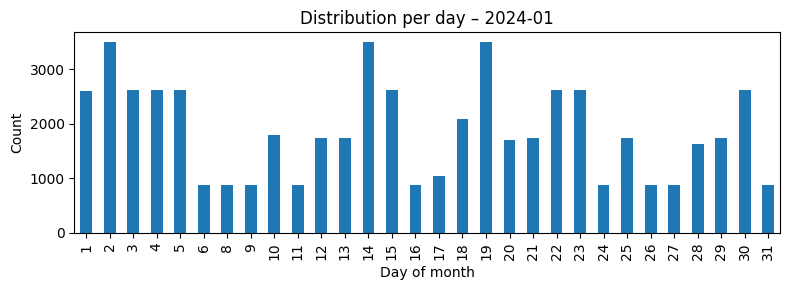

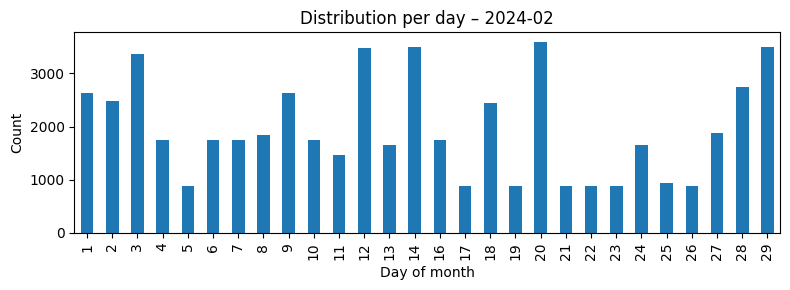

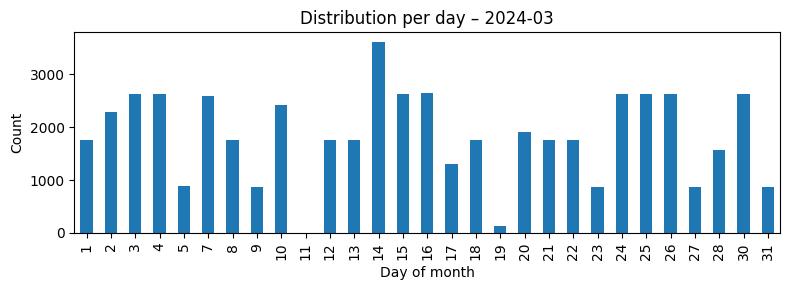

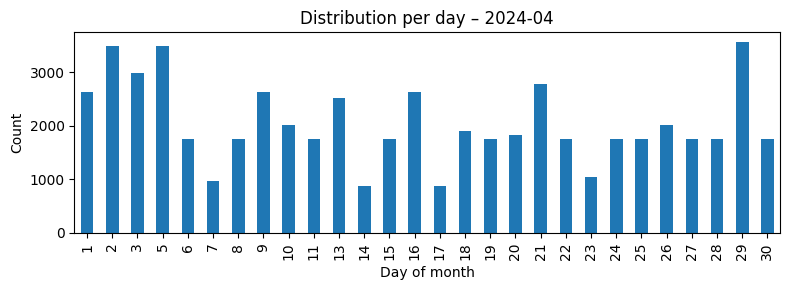

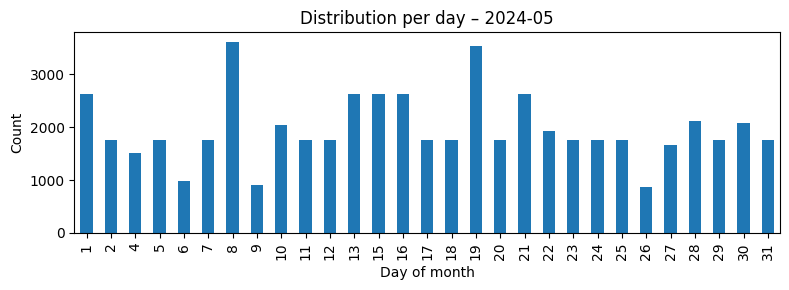

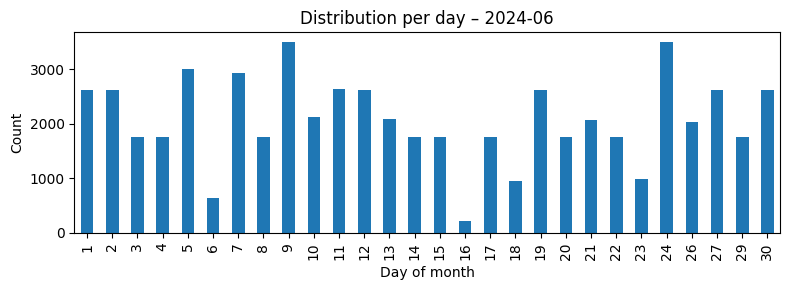

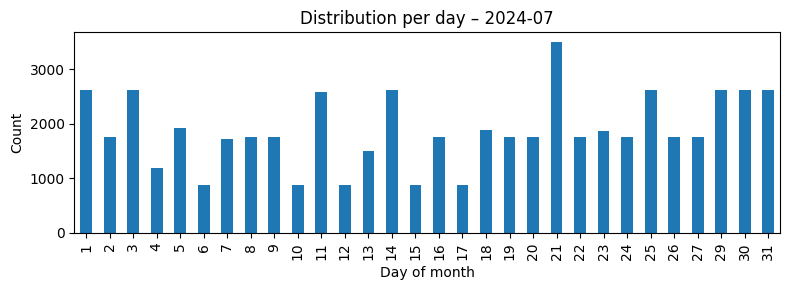

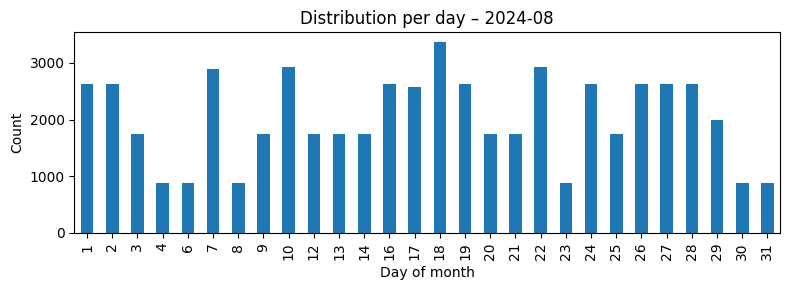

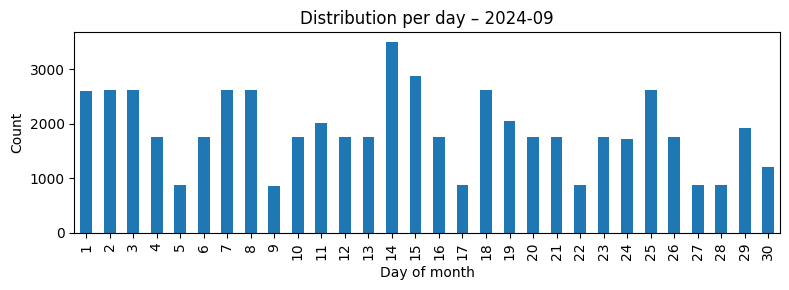

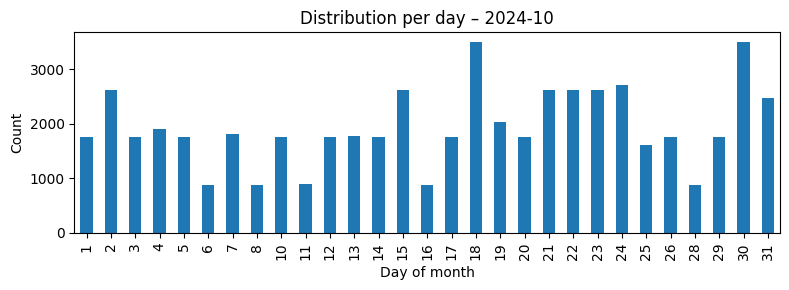

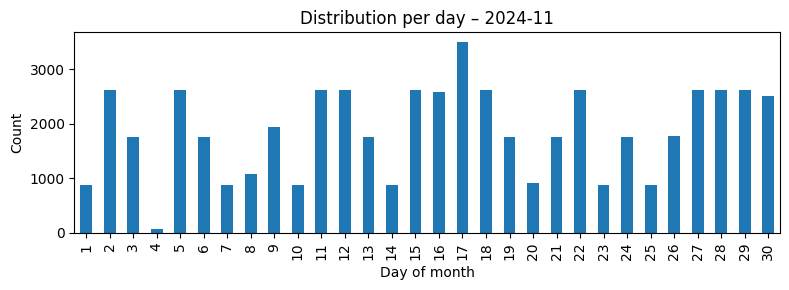

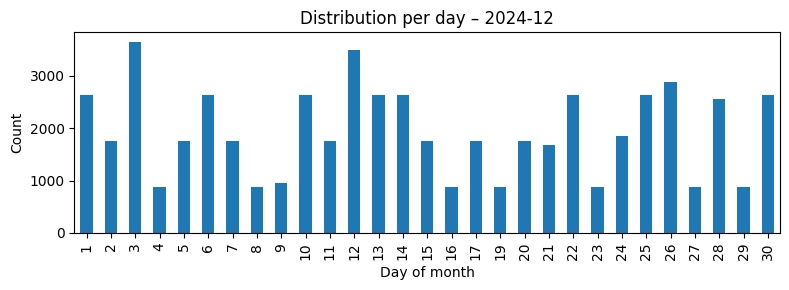

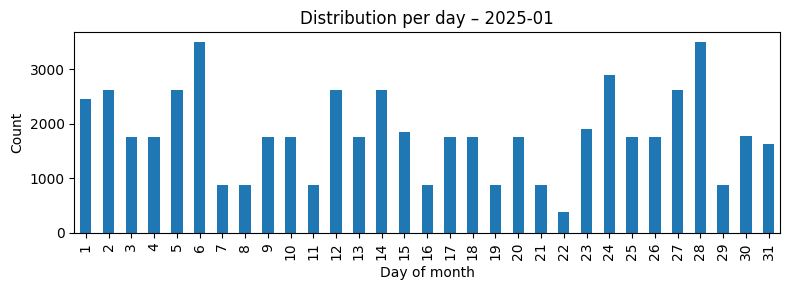

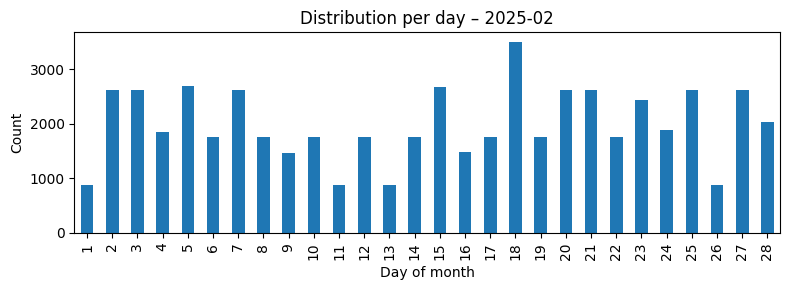

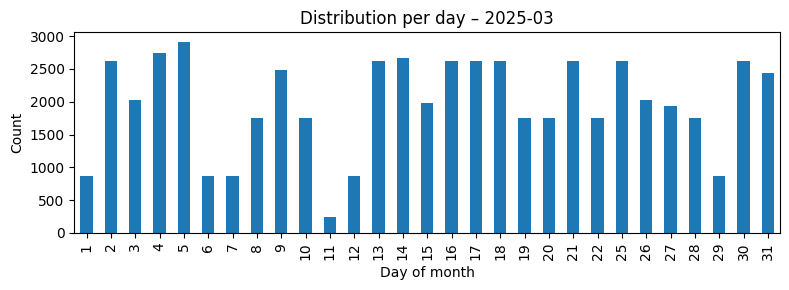

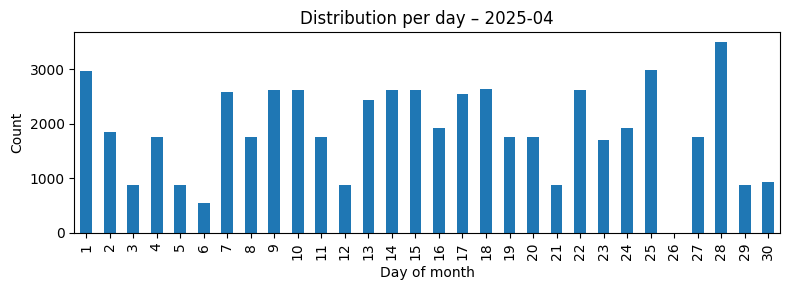

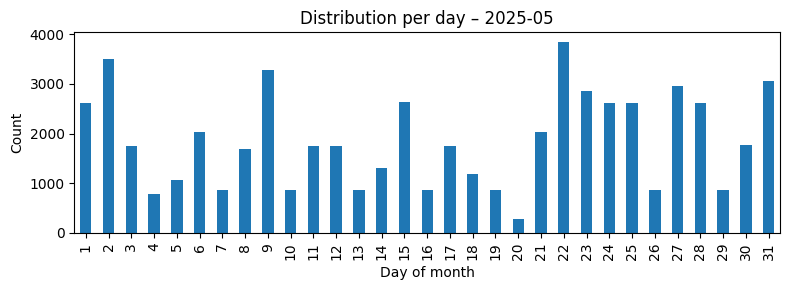

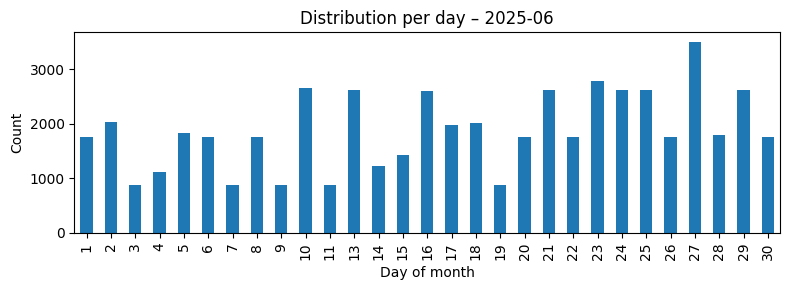

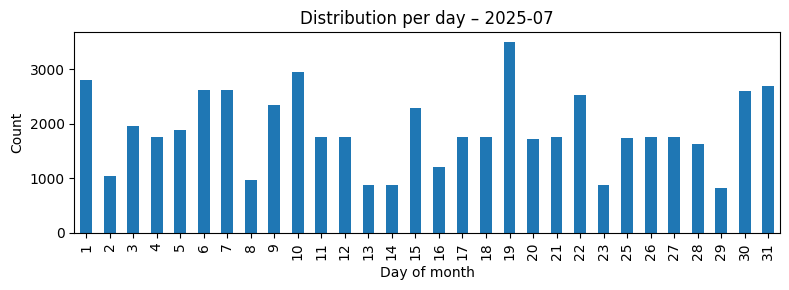

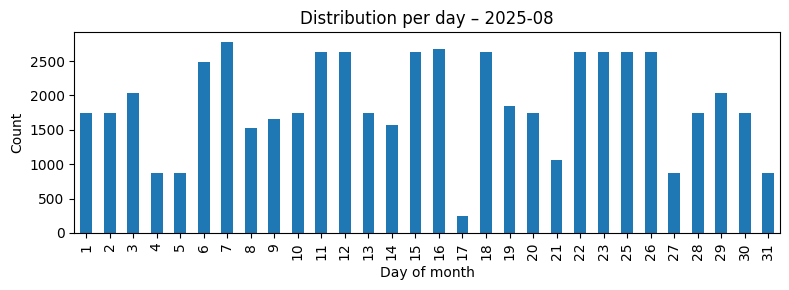

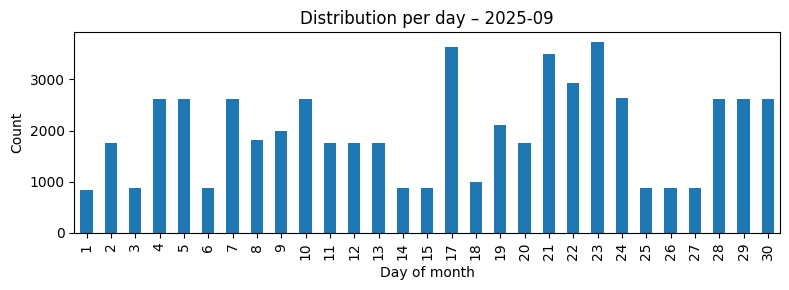

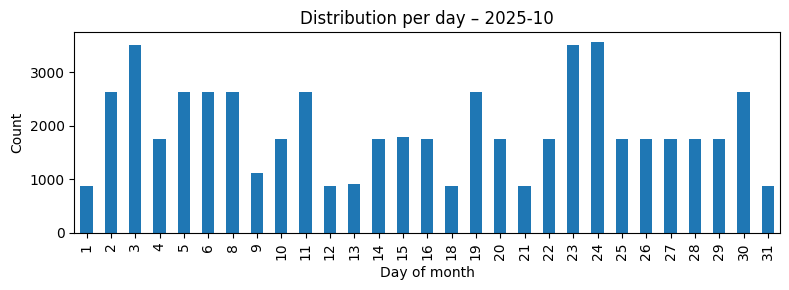

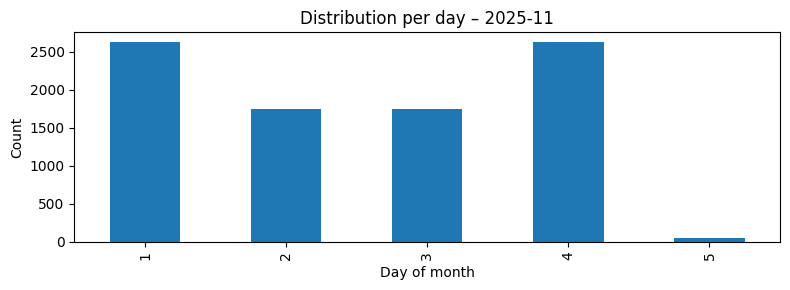

In [2]:
# Testing the import 
# TODO: Test the import
# Read the saved dataset
df_nyc_311_2024_2025 = pd.read_csv("data/nyc_311_2024_2025_sample.csv")
df_nyc_311_2024_2025 = prepare_date_time(df_nyc_311_2024_2025)


for month, group in df_nyc_311_2024_2025.groupby('create_month'):
    # Build DF to test distribution
    counts = group['create_day'].value_counts().sort_index()
    # Test of the distribution
    plt.figure(figsize=(8,3))
    counts.plot(kind='bar')
    plt.title(f"Distribution per day – {month}")
    plt.xlabel("Day of month")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
    # Call the test function    
test_imported_data_distribution_light(df_nyc_311_2024_2025, max_cv=0.5)